In [1]:
#!pipenv install blackcellmagic --dev

In [2]:
%load_ext blackcellmagic

In [3]:
import pandas as pd
df = pd.read_csv("daily.csv")

In [4]:
df =df.set_index("Unnamed: 0")
df.columns.values

array(['Total', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 'WDF2',
       'WSF2'], dtype=object)

In [5]:
df.head()

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,WDF2,WSF2
Unnamed: 0,,,,,,,,,
2012-10-03,3521.0,0,0,0,189,78,73,10,103
2012-10-04,3475.0,0,0,0,189,83,65,20,94
2012-10-05,3148.0,0,0,0,217,89,57,360,80
2012-10-06,2006.0,0,0,0,239,78,51,20,76
2012-10-07,2142.0,0,0,0,239,78,13,30,54


In [6]:
import seaborn
import matplotlib.pyplot as plt

In [7]:
print(df["Total"].dtypes)

float64


In [60]:
class CrawtoML:
    import pandas as pd
    import seaborn

    """
    import pandas
    pandas.DataFrame
    """

    def __init__(self, data, target, features):
        self.data = data
        self.target = target
        self.features = features
        self.numeric_columns = self.numerics()

    def numerics(self):
        numerics = []
        for i in self.features:
            if self.data[i].dtypes in ["int64", "float64"]:
                numerics.append(i)
        self.numeric_columns = numerics
        return self.numeric_columns

    def other_types(self):
        others = [i for i in self.features if i not in self.numeric_columns]
        self.other_types = others
        return self.other_types

    def __repr__(self):
        return "Target Column: %s \n \
        Feature columns: %s\n \
        Numeric Columns: %s"(
            self.target, self.features, self.numeric_columns
        )

    def correlation_report(self):
        seaborn.heatmap(self.data[self.numeric_columns].corr())

    def distribution_report(self):
        self.distribution_r()
        print(seaborn.distplot(self.data[self.target]))
        print(seaborn.PairGrid(self.data, x_vars=self.features, y_vars=self.target).map(
            seaborn.scatterplot
        ))
        

    def distribution_r(self):
        import pandas

        print( pandas.DataFrame(
            [self.distribution_fit(self.data, i) for i in self.numeric_columns + [self.target] ],
            index=self.numeric_columns+[self.target],
        ))

    def distribution_fit(self, data, numeric_column):
        from scipy.stats import shapiro

        """
        x is a column_name
        """
        shapiro_values = shapiro(data[numeric_column])
        test_indication = True if shapiro_values[1] > 0.05 else False

        distribution_types = ["norm", "expon", "logistic", "gumbel"]
        # anderson_values = anderson(automl.data[numeric_column], dist=i)

        return {
            "Shapiro-Wilks_Test_Statistic": shapiro_values[0],
            "Shapiro-Wilks_p_Value": shapiro_values[1],
            "Normal distribution ?": test_indication
            # "Anderson_Darling_Test_Statistic_Normal": anderson_values[0][0],
        }

In [61]:
automl = CrawtoML(
    data=df,
    target="Total",
    features=["PRCP", "SNOW", "SNWD", "TMAX", "TMIN", "AWND", "WDF2", "WSF2"],
)

       Normal distribution ?  Shapiro-Wilks_Test_Statistic  \
PRCP                   False                      0.512445   
SNOW                   False                      0.034132   
SNWD                   False                      0.016631   
TMAX                   False                      0.974404   
TMIN                   False                      0.982076   
AWND                   False                      0.022841   
WDF2                   False                      0.162072   
WSF2                   False                      0.034695   
Total                  False                      0.975116   

       Shapiro-Wilks_p_Value  
PRCP            0.000000e+00  
SNOW            0.000000e+00  
SNWD            0.000000e+00  
TMAX            9.219777e-13  
TMIN            3.608829e-10  
AWND            0.000000e+00  
WDF2            0.000000e+00  
WSF2            0.000000e+00  
Total           1.521083e-12  
AxesSubplot(0.125,0.125;0.775x0.755)


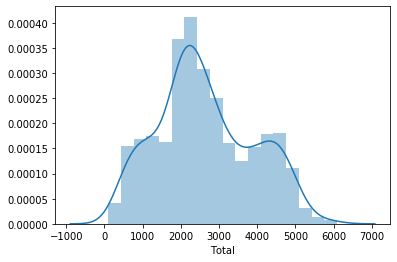

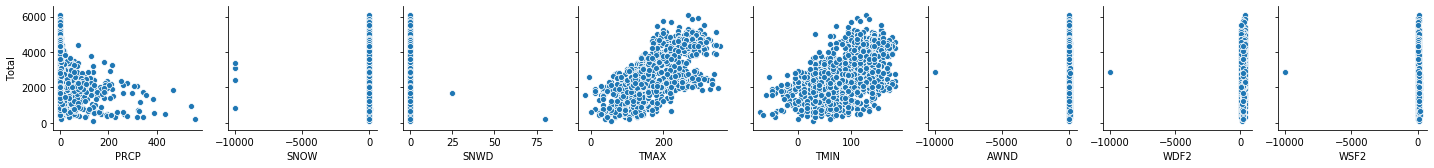

In [62]:
automl.distribution_report()

In [22]:
from scipy.stats import anderson

In [23]:
distribution_types = ['norm','expon','logistic','gumbel']

In [24]:
l = []
for i in distribution_types:
    l.append(anderson(automl.data[automl.numeric_columns[0]], dist=i))

In [25]:
l

[AndersonResult(statistic=189.2992189651368, critical_values=array([0.574, 0.654, 0.784, 0.915, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ])),
 AndersonResult(statistic=inf, critical_values=array([0.921, 1.077, 1.34 , 1.605, 1.956]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ])),
 AndersonResult(statistic=2240.16299856351, critical_values=array([0.426, 0.563, 0.66 , 0.769, 0.906, 1.01 ]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ,  0.5])),
 AndersonResult(statistic=229.52860353312826, critical_values=array([0.471, 0.633, 0.752, 0.872, 1.032]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ]))]

In [15]:
l[0][0]

189.2992189651368

In [16]:
def distribution_fit(data, numeric_column):
        from scipy.stats import shapiro

        """
        x is a column_name
        """
        shapiro_values = shapiro(data[numeric_column])
        test_indication = True if shapiro_values[1] > 0.05 else False

        distribution_types = ["norm", "expon", "logistic", "gumbel"]
        # anderson_values = anderson(automl.data[numeric_column], dist=i)

        return {
            "Shapiro_Wilks_Test_Statistic": shapiro_values[0],
            "Shapiro_Wilks_p_Value": shapiro_values[1],
            "Does the test indicate the data is normally distributed": test_indication
            # "Anderson_Darling_Test_Statistic_Normal": anderson_values[0][0],
        }

In [17]:
distribution_fit(automl.data,automl.numeric_columns[0])

{'Shapiro_Wilks_Test_Statistic': 0.5124454498291016,
 'Shapiro_Wilks_p_Value': 0.0,
 'Does the test indicate the data is normally distributed': False}

((array([-3.2154319 , -2.95158165, -2.80442994, ...,  2.80442994,
          2.95158165,  3.2154319 ]),
  array([-9999, -9999, -9999, ...,    20,    28,    74])),
 (110.66331165898869, -37.46146616541352, 0.18036488362517622))

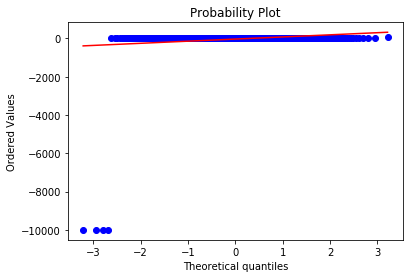

In [18]:
from scipy.stats import probplot
import matplotlib.pyplot as plt
probplot(automl.data[automl.features[1]], plot=plt)

In [ ]:
#!pipenv install plotly

In [ ]:
automl.numeric_columns[0]

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import numpy as np
init_notebook_mode(connected=True)

x = [automl.data[automl.numeric_columns[0]]]

fig = ff.create_distplot(x, [automl.numeric_columns[0]])
iplot(fig, filename='Basic Distplot')